In [2]:
import warnings
import pickle
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold


In [3]:
PATH_TO_DATA = '/home/andrei/Desktop/alice_kaggle'
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')
train_df.sort_values('time1')
#train_df = train_df.loc[:10000]
#test_df = test_df.loc[:10000]
y = train_df['target']
train_df.drop('target', axis=1, inplace=True)
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# filter here by dd[(dd['time1'] > '2013-09-01')]['time1'].hist()

train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11


In [15]:
dd = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
dd['time1'] = dd['time1'].apply(pd.to_datetime)

In [139]:
print(len(dd))
print(len(dd[dd['target'] == 1]))
print(len(dd[dd['target'] == 0]))

print(dd[:10]['time1'].dt.weekday_name)
print(dd[:10]['time1'].dt.dayofweek)

253561
2297
251264
session_id
1     Thursday
2     Saturday
3       Monday
4       Friday
5       Friday
6      Tuesday
7     Thursday
8       Friday
9       Monday
10    Thursday
Name: time1, dtype: object
session_id
1     3
2     5
3     0
4     4
5     4
6     1
7     3
8     4
9     0
10    3
Name: time1, dtype: int64


ValueError: Unknown format code 'd' for object of type 'float'

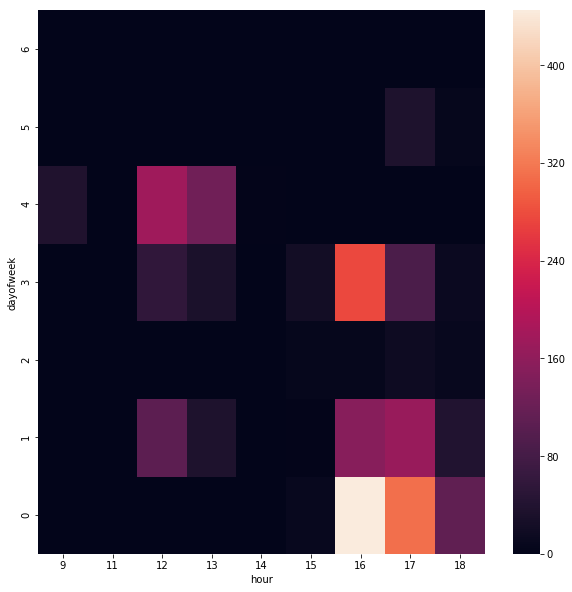

In [135]:
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker


def show_heatmap_dayofweek_hour(df):
    df['dayofweek'] = df['time1'].dt.dayofweek
    df['hour'] = df['time1'].dt.hour


    df['count'] = df.groupby(['dayofweek', 'hour'])['target'].transform("count")
    df = df.drop_duplicates(subset=['dayofweek', 'hour'])
    
    df = resdf.merge(df, on=['dayofweek', 'hour'])
    
    df = df.pivot('dayofweek', 'hour', 'count_y')
    df = df.fillna(0)
    
    f,ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(df, annot=True, fmt="d")
    
show_heatmap_dayofweek_hour(dd[dd['target'] == 1])

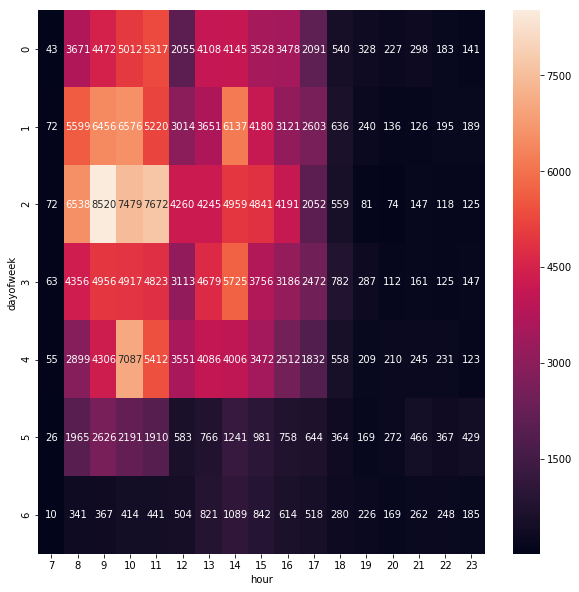

In [131]:
show_heatmap_dayofweek_hour(dd[dd['target'] == 0])

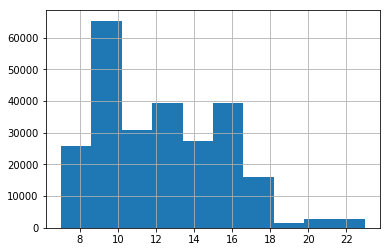

In [143]:
dd['hour'] = dd['time1'].dt.hour
dd[dd['target'] == 0]['hour'].hist()

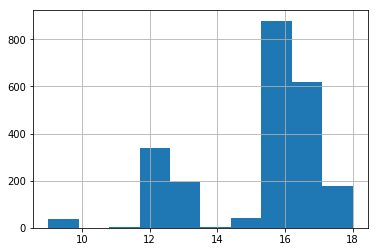

In [144]:
dd['hour'] = dd['time1'].dt.hour
dd[dd['target'] == 1]['hour'].hist()

In [4]:
# загрузим словарик сайтов
with open(r"/home/andrei/Desktop/alice_kaggle/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# датафрейм словарика сайтов
sites_dict_df = pd.DataFrame(list(site_dict.keys()), 
                          index=list(site_dict.values()), 
                          columns=['site'])
print(u'всего сайтов:', sites_dict_df.shape[0])

text_columns = ['site_column%s' % i for i in range(1, 11)]
train_df['text_col'] = ''
test_df['text_col'] = ''

for i in range(1, 11):
    site_c = 'site{}'.format(i)
    site_name_c = 'site_column{}'.format(i)
    train_df[site_name_c] = sites_dict_df.loc[train_df[site_c]].values
    test_df[site_name_c] = sites_dict_df.loc[test_df[site_c]].values
    train_df['text_col'] += train_df[site_name_c]
    test_df['text_col'] += test_df[site_name_c]
    
print(train_df.head())

all_train_text = pd.concat([train_df['site_column{}'.format(i)].astype('U') for i in range(1, 11)])  
char_vec = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), max_features=100000)
word_vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), max_features=100000)
# fix wordofvec
word_vec.fit(all_train_text.astype('U'))

всего сайтов: 48371
            site1               time1  site2               time2    site3  \
session_id                                                                  
1             718 2014-02-20 10:02:45    NaN                 NaT      NaN   
2             890 2014-02-22 11:19:50  941.0 2014-02-22 11:19:50   3847.0   
3           14769 2013-12-16 16:40:17   39.0 2013-12-16 16:40:18  14768.0   
4             782 2014-03-28 10:52:12  782.0 2014-03-28 10:52:42    782.0   
5              22 2014-02-28 10:53:05  177.0 2014-02-28 10:55:22    175.0   

                         time3    site4               time4  site5  \
session_id                                                           
1                          NaT      NaN                 NaT    NaN   
2          2014-02-22 11:19:51    941.0 2014-02-22 11:19:51  942.0   
3          2013-12-16 16:40:19  14769.0 2013-12-16 16:40:19   37.0   
4          2014-03-28 10:53:12    782.0 2014-03-28 10:53:42  782.0   
5          2014-02-2

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [5]:
X_tfidf = word_vec.transform(pd.concat((train_df['text_col'], test_df['text_col'])).values.astype('U'))

In [13]:
alice_common = dict()
for i in range(1, 11):
    a = train_df[y == 0]['site_column%s' % i].value_counts()
    for k, v in dict(a).items():
        alice_common.setdefault(k, 0)
        alice_common[k] += v
alice_common = list(alice_common.items())
alice_common.sort(key=lambda x: x[1], reverse=True)
alice_common = set([_[0] for _ in alice_common[:10]])


def get_part_from_hour(h):
    return h//3


def get_session_duration(row):
    time_values = row[['time%s' % i for i in range(1, 10)]].dropna().values
    duration = (time_values.max() - time_values.min()).total_seconds()
    return duration


def get_count_of_good_sites(row):
    res = 0
    for i in range(1, 11):
        res += row['site_column%s' % i] in alice_common
    return res


def add_extra_features(df):
    df['hour'] = df['time1'].dt.hour
    
    for i in range(2, 4):
        df['delta%s' % (i-1)] = (df['time%s' % i] - df['time%s' % (i-1)]).dt.total_seconds()

    #df['duration'] = df.apply(get_session_duration, axis=1)
    
    df['count_good'] = df.apply(get_count_of_good_sites, axis=1)
    
    return df


def get_scaled_features(df):
    scalable_columns = ['hour', 'delta1',  'count_good'] # 'duration']
    return MinMaxScaler().fit_transform(df[scalable_columns].fillna(-1))


def get_OH(df):
    df['part_of_day'] = np.array(list(map(lambda v: get_part_from_hour(v), df['time1'].dt.hour)))
    
    df['hour'] = df['time1'].dt.hour
    df['is_work_time'] = df['hour'].apply(lambda x: 8 <= x <= 17)
    
    df['dayofweek'] = df['time1'].dt.dayofweek
    
    
    
    return OneHotEncoder().fit_transform(df[['part_of_day', 'is_work_time', 'dayofweek', ]])


def get_extra_features(df):
    return get_scaled_features(add_extra_features(df))

In [6]:
dir(train_df['time1'].dt)

['__bytes__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_accessors',
 '_add_delegate_accessors',
 '_constructor',
 '_delegate_method',
 '_delegate_property_get',
 '_delegate_property_set',
 '_deprecations',
 '_dir_additions',
 '_dir_deletions',
 '_freeze',
 '_make_accessor',
 '_reset_cache',
 'ceil',
 'date',
 'day',
 'dayofweek',
 'dayofyear',
 'days_in_month',
 'daysinmonth',
 'floor',
 'freq',
 'hour',
 'is_leap_year',
 'is_month_end',
 'is_month_start',
 'is_quarter_end',
 'is_quarter_start',
 'is_year_end',
 'is_year_start',
 'microsecond',
 'minute',
 'month',
 'nanosecond',
 'normalize',
 'quarter',
 'round',
 'second',
 'strftime',
 'time',
 'to_period',
 'to_

In [11]:
full_df = pd.concat([train_df, test_df])
sites = ['site%s' % i for i in range(1, 11)]
# Index to split the training and test data sets
idx_split = train_df.shape[0]
full_sites = full_df[sites]
full_sites.head()

sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [67]:
%%time
_train = pd.concat((train_df, test_df))
X_train = hstack([#full_sites_sparse, X_tfidf,
                  get_OH(_train), 
                  get_extra_features(_train)
                 ], format='csr')


CPU times: user 1min 2s, sys: 324 ms, total: 1min 3s
Wall time: 1min 3s


In [19]:
def get_auc_lr_valid(X, y, C=0.07, seed=17, ratio = 0.7):
    idx = int(round(X.shape[0] * ratio))
    lr = LogisticRegression(C=C, random_state=seed, n_jobs=-1).fit(X[:idx, :], y[:idx])
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [36]:
tscv = TimeSeriesSplit(n_splits=3)
lr = LogisticRegression(random_state=17, n_jobs=-1)
param_search = {'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]}
lrg = GridSearchCV(estimator=lr, cv=tscv,
                   param_grid=param_search)
lrg.fit(X_train[:idx_split], y)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
dir(lrg)
print(lrg.best_params_)
print(lrg.cv_results_)
print(lrg.best_score_)

{'C': 0.07}
{'mean_score_time': array([0.01017459, 0.00935976, 0.01332903, 0.01039131, 0.00970117,
       0.01319734, 0.01209593]), 'split2_train_score': array([0.99123946, 0.9916391 , 0.99184944, 0.99198616, 0.99209659,
       0.99222279, 0.99233322]), 'mean_fit_time': array([1.2160279 , 1.50634638, 1.59820414, 1.52268227, 1.57566627,
       1.756404  , 1.81450391]), 'split1_train_score': array([0.99081881, 0.99117376, 0.99137883, 0.9915287 , 0.99154447,
       0.99167856, 0.99178899]), 'mean_train_score': array([0.99096957, 0.99125791, 0.99145948, 0.99161811, 0.99169698,
       0.99183107, 0.99195202]), 'rank_test_score': array([7, 6, 5, 4, 3, 2, 1], dtype=int32), 'std_train_score': array([0.00019128, 0.00028321, 0.00029112, 0.00027148, 0.00028519,
       0.00027924, 0.00027049]), 'split0_test_score': array([0.99055056, 0.99059789, 0.99077142, 0.99085029, 0.99086607,
       0.99091339, 0.99096072]), 'std_score_time': array([0.00032204, 0.00015624, 0.00258453, 0.00111087, 0.00025285,


In [68]:
%%time
print(get_auc_lr_valid(X_train[:idx_split], y, C=5))

0.877095045969156
CPU times: user 773 ms, sys: 0 ns, total: 773 ms
Wall time: 772 ms


In [94]:
from xgboost import XGBClassifier
def get_auc_xgboost_valid(X, y, seed=17, ratio = 0.4):
    idx = int(round(X.shape[0] * ratio))
    lr = XGBClassifier(random_state=seed, n_jobs=-1, scorring='roc_auc', max_depth=6).fit(X[:idx, :], y[:idx])
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [95]:
%%time
print(get_auc_xgboost_valid(X_train[:idx_split], y))

0.9515741327570246
CPU times: user 11.3 s, sys: 20.1 ms, total: 11.4 s
Wall time: 3.4 s


In [43]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [60]:
%%time
#lr = LogisticRegression(C=5, random_state=17, n_jobs=-1).fit(X_train[:idx_split], y)
lr = XGBClassifier(random_state=17, n_jobs=-1, scorring='roc_auc').fit(X_train[:idx_split], y)
X_test = X_train[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'alice.csv')

CPU times: user 1min 31s, sys: 548 ms, total: 1min 31s
Wall time: 32.3 s
